# TabNet Model Test

In this notebook, we'll test a training loop for the TabNet model 


In [1]:
import sys
sys.path.append('../src')

from models.lib.neural import *
from models.lib.data import *
from models.lib.train import *

import helper 
from helper import gene_intersection
from pytorch_tabnet.tab_network import TabNet

import torch.nn as nn 
import torch.optim as optim
import torch
from tqdm import tqdm
from torch.utils.data import Subset
from helper import seed_everything

seed_everything(42)

First, we'll define our train, val and test sets, then generate the associated DataLoaders and try training.

In [2]:
t = helper.INTERIM_DATA_AND_LABEL_FILES_LIST
datafiles, labelfiles = zip(*t.items())
datafiles = [f'../data/interim/{f}' for f in datafiles]
labelfiles = [f'../data/processed/labels/{f}' for f in labelfiles]

datafiles, labelfiles

(['../data/interim/primary_bhaduri_T.csv',
  '../data/interim/allen_cortex_T.csv',
  '../data/interim/allen_m1_region_T.csv',
  '../data/interim/whole_brain_bhaduri_T.csv'],
 ['../data/processed/labels/primary_bhaduri_labels.csv',
  '../data/processed/labels/allen_cortex_labels.csv',
  '../data/processed/labels/allen_m1_region_labels.csv',
  '../data/processed/labels/whole_brain_bhaduri_labels.csv'])

In [3]:
train_loader, val_loader, test_loader = generate_loaders(
    datafiles,
    labelfiles,
    'Type',
    num_workers=0,
    collocate=False,
)

refgenes = gene_intersection()

In [4]:
from models.lib.neural import TabNetGeneClassifier

model = TabNetGeneClassifier(
    input_dim=len(refgenes),
    output_dim=19
)

In [5]:
sample = next(iter(train_loader[0]))[0]
sample = clean_sample(sample, refgenes, train_loader[0].dataset.columns)
sample

tensor([[1.1458, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8902, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [6]:
model(sample)

tensor([[-2.3695, -1.6859,  0.3932,  0.7834,  0.5724,  0.1285,  2.0458, -0.5353,
          0.1072,  2.2878, -2.6266, -0.0060, -1.3519, -0.2654,  0.2857,  1.3722,
         -2.1647, -2.0168,  0.2252],
        [ 1.7041, -0.0514, -1.1603,  0.8445,  0.3909, -0.5014,  0.8765,  0.3303,
          0.6350,  0.0367,  0.6937, -0.2794,  0.1761, -0.3965, -0.6405,  0.9846,
         -1.6215,  0.5126,  1.2953],
        [ 0.4198, -1.7357, -1.4540,  0.9354, -0.1871,  0.1724,  1.1644, -1.0471,
          0.1651, -0.5473, -1.2712, -0.4917, -1.0942, -0.3880,  0.5926,  0.2460,
         -1.1279,  0.5290, -0.1490],
        [ 0.3247,  0.0626, -0.4729, -0.0760, -0.9306,  0.1010,  2.7008, -1.3465,
          0.4771,  0.3002, -0.5355, -0.5808, -1.0911, -0.2043,  0.5783, -0.8588,
         -0.1487, -0.3219,  0.8527]], grad_fn=<MmBackward0>)

Now, we'll subset and define our DataLoaders

In [7]:
import wandb
from torchmetrics.functional import accuracy

wandb.init()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss = []
val_loss = []
test_loss = []

mod = 10
wandb.watch(model)
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    # Train loop
    model.train()
    for idx, train in enumerate(train_loader):
        print(f'On loader {idx = }')
        for i, data in enumerate(train):
            print(f'On minibatch {i = }/10')
            if i == 10:
                break 
            inputs, labels = data
            # CLEAN INPUTS
            inputs = clean_sample(inputs, refgenes, train.dataset.columns)
            # Forward pass ➡
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass ⬅
            optimizer.zero_grad()
            loss.backward()

            # Step with optimizer
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss += loss.item()


            if i % mod == 0: # record every 2000 mini batches 
                metric_results = calculate_metrics(
                    outputs=outputs,
                    labels=labels,
                    append_str='train',
                    num_classes=model.output_dim,
                    subset='weighted_accuracy',
                )

                wandb.log(metric_results)
                running_loss = running_loss / mod
                wandb.log({f"batch_train_loss": loss})

                running_loss = 0.0
            
    wandb.log({f"epoch_train_loss": epoch_loss / len(train)})
    
    model.eval()
    with torch.no_grad(): # save memory but not computing gradients 
        running_loss = 0.0
        epoch_loss = 0.0
        
        for val in val_loader:
            print(f'On loader {i = }')
            for i, data in enumerate(val):
                if i == 10:
                    break 
                inputs, labels = data
                # CLEAN INPUTS
                inputs = clean_sample(inputs, refgenes, val.dataset.columns)
                # Forward pass ➡
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % mod == 0: #every 2000 mini batches 
                    running_loss = running_loss / mod
                    wandb.log({"val_loss": loss})
                    running_loss = 0.0

                    metric_results = calculate_metrics(
                        outputs=outputs,
                        labels=labels,
                        num_classes=model.output_dim,
                        subset='weighted_accuracy',
                        append_str='val',
                    )

                wandb.log(metric_results)
    
        wandb.log({f"epoch_val_loss": epoch_loss / len(train)})


wandb: Currently logged in as: jlehrer1 (use `wandb login --relogin` to force relogin)


On loader idx = 0
On minibatch i = 0/10
On minibatch i = 1/10
On minibatch i = 2/10
On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10
On minibatch i = 6/10
On minibatch i = 7/10
On minibatch i = 8/10
On minibatch i = 9/10
On minibatch i = 10/10
On loader idx = 1
On minibatch i = 0/10
On minibatch i = 1/10
On minibatch i = 2/10
On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10
On minibatch i = 6/10
On minibatch i = 7/10
On minibatch i = 8/10
On minibatch i = 9/10
On minibatch i = 10/10
On loader idx = 2
On minibatch i = 0/10
On minibatch i = 1/10
On minibatch i = 2/10
On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10
On minibatch i = 6/10
On minibatch i = 7/10
On minibatch i = 8/10
On minibatch i = 9/10
On minibatch i = 10/10
On loader idx = 3
On minibatch i = 0/10
On minibatch i = 1/10
On minibatch i = 2/10
On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10
On minibatch i = 6/10
On minibatch i = 7/10
On minibatch i = 8/10
O

In [8]:
model

TabNetGeneClassifier(
  (embedder): EmbeddingGenerator()
  (tabnet): TabNetNoEmbeddings(
    (initial_bn): BatchNorm1d(16604, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (encoder): TabNetEncoder(
      (initial_bn): BatchNorm1d(16604, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (initial_splitter): FeatTransformer(
        (shared): GLU_Block(
          (shared_layers): ModuleList(
            (0): Linear(in_features=16604, out_features=32, bias=False)
            (1): Linear(in_features=16, out_features=32, bias=False)
          )
          (glu_layers): ModuleList(
            (0): GLU_Layer(
              (fc): Linear(in_features=16604, out_features=32, bias=False)
              (bn): GBN(
                (bn): BatchNorm1d(32, eps=1e-05, momentum=0.02, affine=True, track_running_stats=True)
              )
            )
            (1): GLU_Layer(
              (fc): Linear(in_features=16, out_features=32, bias=False)
              

In [9]:
def test_loop(
    model,
    testloaders,
    refgenes,
    criterion,
    mod,
):
    model.eval()
    
    with torch.no_grad():
        for idx, test in enumerate(testloaders):
            print(f'On {idx = }')
            running_loss = 0.0
            for i, data in enumerate(test):
                print(f'minibatch {i = }')
                if i == 10:
                    break
                inputs, labels = data
                # CLEAN INPUTS
                inputs = clean_sample(inputs, refgenes, test.dataset.columns)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # print statistics
                running_loss += loss.item()
                if i % mod == 0: #every 2000 mini batches 
                    running_loss = running_loss / mod
                    wandb.log({"test_loss": loss})
                    running_loss = 0.0

                    metric_results = calculate_metrics(
                        outputs=outputs,
                        labels=labels,
                        num_classes=model.output_dim,
                        subset='weighted_accuracy',
                        append_str='test',
                    )

                    wandb.log(metric_results)


In [10]:
test_loop(model, test_loader, refgenes, criterion, mod)

On idx = 0
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10
On idx = 1
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10
On idx = 2
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10
On idx = 3
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10


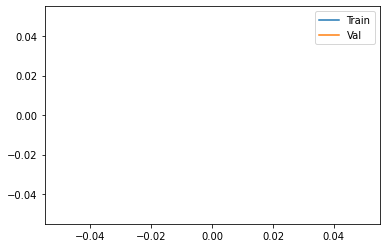

In [14]:
import matplotlib.pyplot as plt 

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.show()

In [10]:
labelfiles

['../data/processed/labels/primary_bhaduri_labels.csv',
 '../data/processed/labels/allen_cortex_labels.csv',
 '../data/processed/labels/allen_m1_region_labels.csv',
 '../data/processed/labels/whole_brain_bhaduri_labels.csv']

In [12]:
from numpy import memmap

In [15]:
f = memmap('../data/interim/allen_cortex_T.csv', dtype=np.float64, mode='r')

ValueError: Size of available data is not a multiple of the data-type size.